# Python Geopandas

## Introduction

In this notebook, we’ll look at Python’s geopandas and shapely libraries to draw maps and explore geospatial concepts.
The notebook illustrates how to read a shapefile and plot it, plot arbitrary points on a map, create a map with layers and produce a heat map.  We’ll illustrate these concepts using real data from the Colorado Oil & Gas Conservation Commission to show the position of crude oil production relative to Colorado’s population centers.

## Preliminaries

### Libraries

We need the usual suspects: `numpy` and `pandas` and in addition, `geopandas` and `shapely`.
`geopandas` has a dependency on `shapely` so these libraries can be installed via
`
    conda install -c conda-forge geopandas
`

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
import zipfile
import matplotlib.pyplot as plt

%matplotlib inline

### Data Wrangling

This notebook uses data from the [Colorado Oil and Gas Conservation Commission](http://cogcc.state.co.us/#/home).
The 2017 data comes from [here](http://cogcc.state.co.us/documents/data/downloads/production/co%202017%20Annual%20Production%20Summary-xp.zip). The data downloads as a zip file; when unzipped it produces a Microsoft Access Database.
The database contains two tables, one describing oil and gas wells and the other providing production (output) data.

To avoid a lot of unnecessary detail, these two tables have been exported to `.csv` files called `WellData.csv` and `Production.csv`

The data wrangling below does this:
* Excludes well records that have no longitude and latitude coordinates
* Elimates duplicate records for a given well identifier (API_num) by  picking the first record for each API_num
* Sums up oil production and operating days for each unique well identified by and API_num
* Excludes any production record on which the production value or the operating days is NA
* Joins the well and production data frames so that we're left with a data frame that contains the well's API_num, geo-coordinates, production and operating days.

In [2]:
# Opens zip file and creates data directory
# If files get large, will need to check to see if exists, and only replace new ones (or updates)
zip_ref = zipfile.ZipFile('./data.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [3]:
# read up the well data:
WellData_Raw = pd.read_csv("./data/welldata/WellData.csv",low_memory=False)

# get rid of the dup API nummber records by taking first in group
DimWell = WellData_Raw.groupby('API_num').first()

# ditch the wells for which there's no longitude or latitude:
DimWell.dropna(axis=0, how='any', subset=['long','lat'],inplace=True)

In [4]:
DimWell.name.isnull().sum(), len(DimWell)

(0, 73810)

In [5]:
def makeapinum(cnty, seq, sidetrack, st='05'):
    APInum = st + '-' + str(cnty).zfill(3) + '-' + str(seq).zfill(5) + '-' + \
                                            str(sidetrack).zfill(2)
    return APInum

In [6]:
# read up the production data
ProductionData_Raw = pd.read_csv("./data/welldata/Production.csv", low_memory=False)

# tack on an API code:
ProductionData_Raw['API_num'] = ProductionData_Raw.apply(lambda c:makeapinum(c.api_county_code, c.api_seq_num, c.sidetrack_num), axis=1)

# sum up the production data for each well:
FactProduction = ProductionData_Raw[['API_num','Prod_days','oil_prod']].groupby('API_num').sum()

# ditch the records for which there's no production data:
FactProduction.dropna(axis=0, how='any',inplace=True)

# join the Well data to the produciton data:
dimcols = ['long','lat', 'formation_code']
oil_df = FactProduction.merge(DimWell[dimcols], left_index=True, right_index=True)

In [7]:
len(DimWell), len(FactProduction), len(oil_df)

(73810, 33010, 33009)

Here is the resulting data frame which we will use through out this notebook:

In [8]:
oil_df.sort_values('oil_prod',ascending=False).head()[['oil_prod','Prod_days','lat','long']]

,oil_prod,Prod_days,lat,long
API_num,,,,
05-123-41990-00,276767.0,365.0,40.423240,-104.355260
05-123-41991-00,270806.0,365.0,40.423344,-104.355260
05-123-43250-00,268426.0,323.0,40.440348,-104.924943
05-123-41987-00,229892.0,365.0,40.423550,-104.355250
05-123-41988-00,227726.0,365.0,40.423340,-104.355260


The figure below shows that the vast majority of wells produced fewer than 400 barrels of crude oil in 2017 and that
about 5000 of the 33,000 producing oil wells produced about 90% of the total crude oil output.

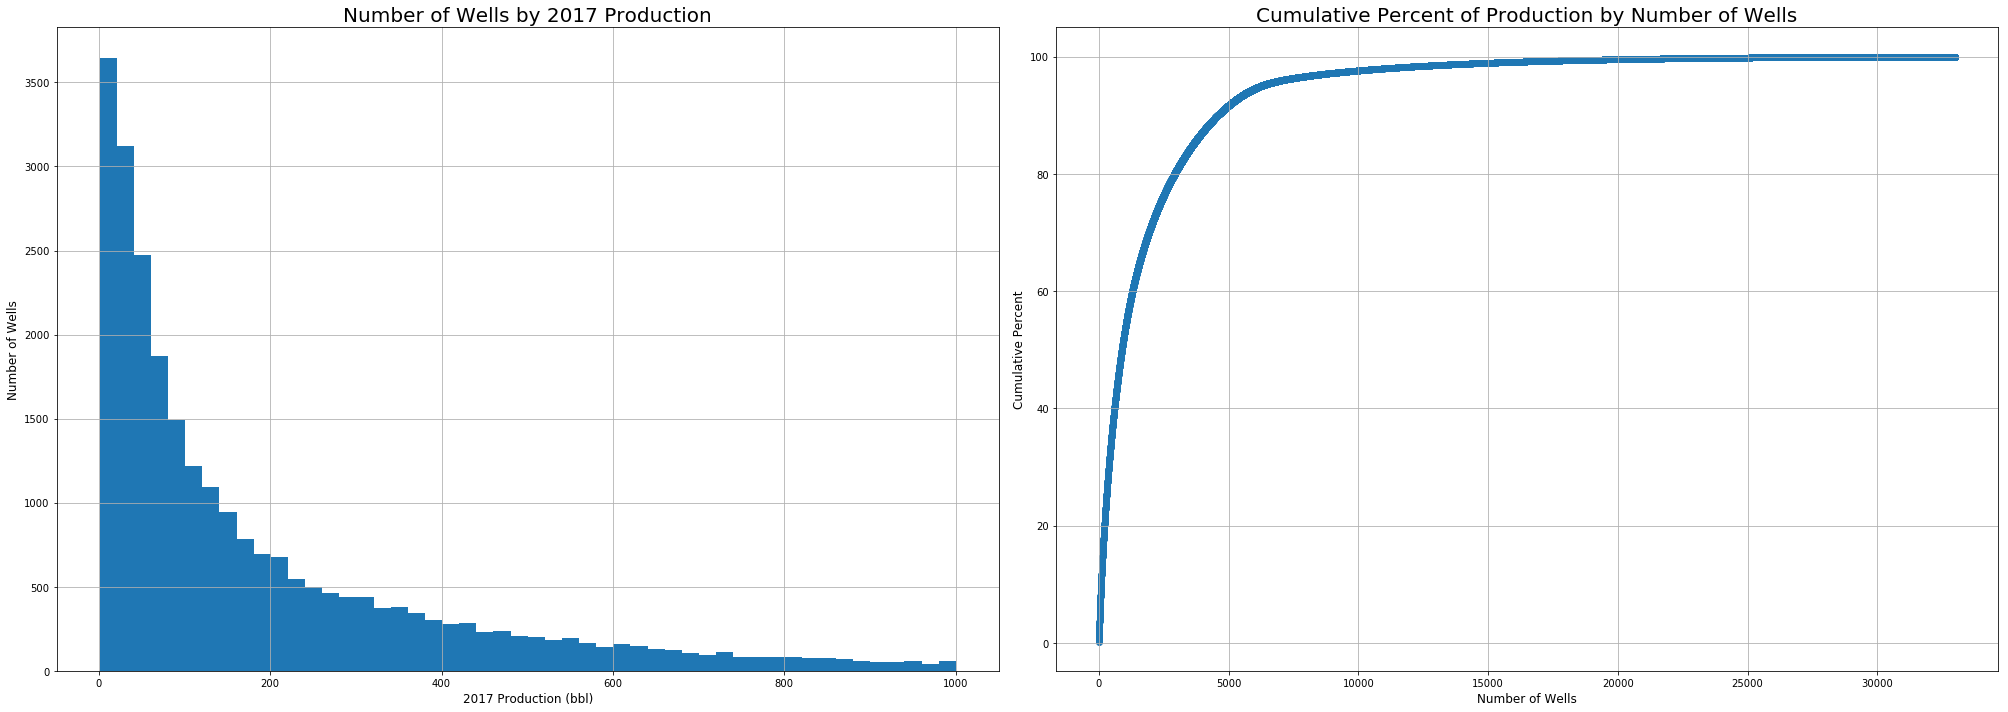

In [9]:
oil_prod =np.sort(oil_df.oil_prod.values)[::-1].cumsum()/oil_df.oil_prod.sum()*100.0

f = plt.figure(figsize=(28,10))
ax = plt.subplot(1,2,1)
oil_df.query('oil_prod <= 1000').hist('oil_prod',ax=ax,bins=50)
plt.title('Number of Wells by 2017 Production', size=20)
plt.ylabel('Number of Wells',size=12)
plt.xlabel('2017 Production (bbl)',size=12)

ax = plt.subplot(1,2,2)
plt.scatter(np.arange(len(oil_prod)), oil_prod)
plt.title('Cumulative Percent of Production by Number of Wells', size=20)
plt.ylabel('Cumulative Percent',size=12)
plt.xlabel('Number of Wells', size=12)
plt.grid()
plt.tight_layout()

## Shapefiles

Shapefiles appear commonly in geospatial applications and analyses.  They contain point, line and polygon data that consuming applications (Python in our case) project onto a two dimensional surface.  Shapefiles can be thought of as containing an array of records, one record for each feature.
Each record contains geometry information describing the shape (point, line or polygon) and usually some property information describing the feature, e.g., the feature's name.

Shape files come from a variety of sources, the US Census Bureau supplies shape for many goverment administrative regions such as states, counties, zip code tabulation areas and census block, block groups and tracts.
Shapefiles download (typically) as zip archives, which unzipped, produce a small collection of related files.  The file with the *.shp* extenstion contains the geometric object for each feature, the *.dbf* file contains the feature property information.

For this notebook, the US Census Bureau provided a shapefile of US Counties [here](http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_20m.zip). This file was downloaded and unzipped into the `./data/shapefiles/US County` directory.

`geopandas` easily reads a shapefile with the `read_file` function and produces a geopandas.dataframe as follows:

In [10]:
sf_path = "./data/shapefiles/US County/cb_2016_us_county_20m.shp"
us_county_sf = gpd.read_file(sf_path)

In [11]:
type(us_county_sf)

geopandas.geodataframe.GeoDataFrame

`geopandas` inherits from `pandas` so just about everything you can do with a pandas dataframe, you can do with a geopandas dataframe.

In [12]:
us_county_sf.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,39,131,01074078,0500000US39131,39131,Pike,06,1140324458,9567612,"POLYGON ((-83.35353099999999 39.197585, -82.78..."
1,46,003,01266983,0500000US46003,46003,Aurora,06,1834813753,11201379,"POLYGON ((-98.807771 43.935223, -98.331508 43...."
2,55,035,01581077,0500000US55035,55035,Eau Claire,06,1652211310,18848512,"POLYGON ((-91.65045499999999 44.855951, -90.92..."
3,72,145,01804553,0500000US72145,72145,Vega Baja,13,118766803,57805868,"POLYGON ((-66.448989 18.387214, -66.4389500073..."
4,48,259,01383915,0500000US48259,48259,Kendall,06,1715747531,1496797,"POLYGON ((-98.920147 30.13829, -98.587897 30.1..."


In [13]:
len(us_county_sf)

3220

There's one row per feature. According the Census Bureau, there 3220 counties in the US.

What's special about a `GeoDataFrame` is the geometry column. This column captures the geometric type (point, line or polygon) of the feature and the coordinates of where to place this feature. Print out a geometry object to see its shape:

In [14]:
type(us_county_sf.geometry.iloc[0])

shapely.geometry.polygon.Polygon

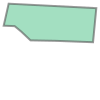

In [15]:
us_county_sf.iloc[0].geometry

### Plotting

Conveniently enough:

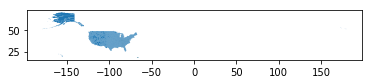

In [16]:
us_county_sf.plot()

### Clipping

To zoom in on a particular area, first get the lower-left and upper-right coordinates of the zoom area. Then set the x and y limits as follows:

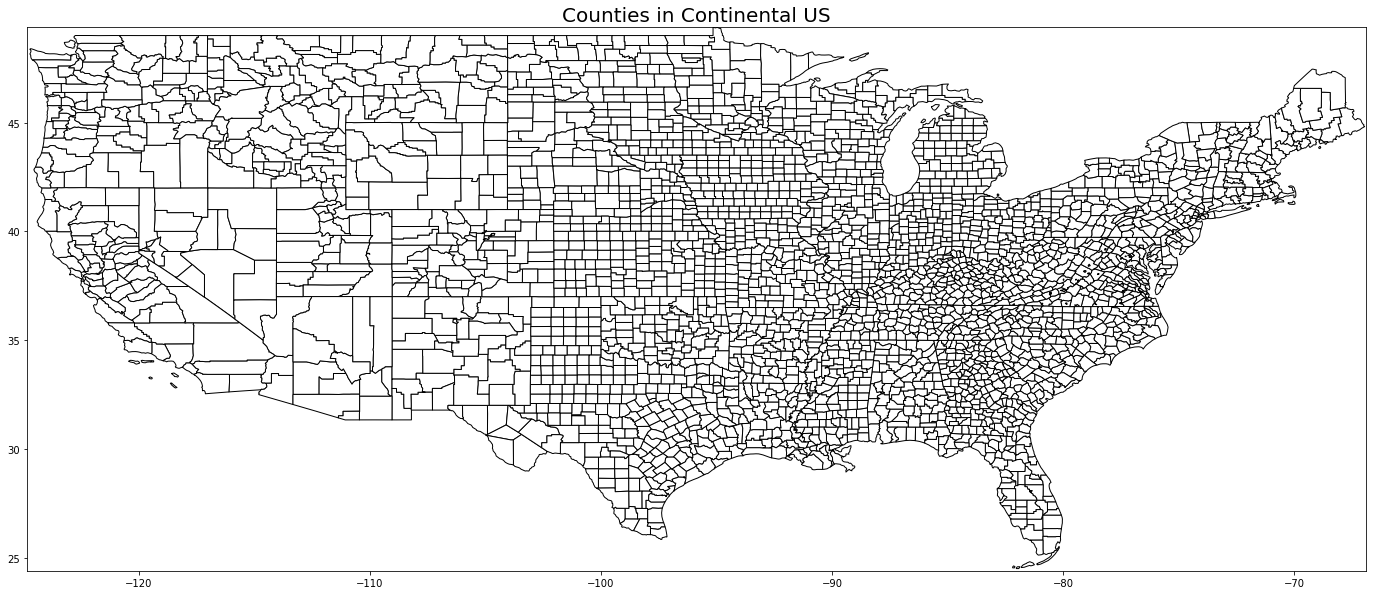

In [17]:
#from Google, coords for continental US:
x0,y0 = (-124.848974, 24.396308)
x1,y1 = (-66.885444, 49.384358)

fig, ax = plt.subplots(1,figsize=(24,10))
ax.set_xlim(x0,x1)
ax.set_ylim(y0,y1)
us_county_sf.plot(ax=ax,facecolor="white",edgecolor="black")
plt.title('Counties in Continental US', size=20)


### Filtering

As with a `pandas` dataframe, the `query` method allows you to filter to just the features you're interested in. Below we'll create a geopandas dataframe for just the Colorado counties.

In [18]:
co_FIP = '08' # Colorado state FIPS code
co_county_sf=us_county_sf.query('STATEFP==@co_FIP')

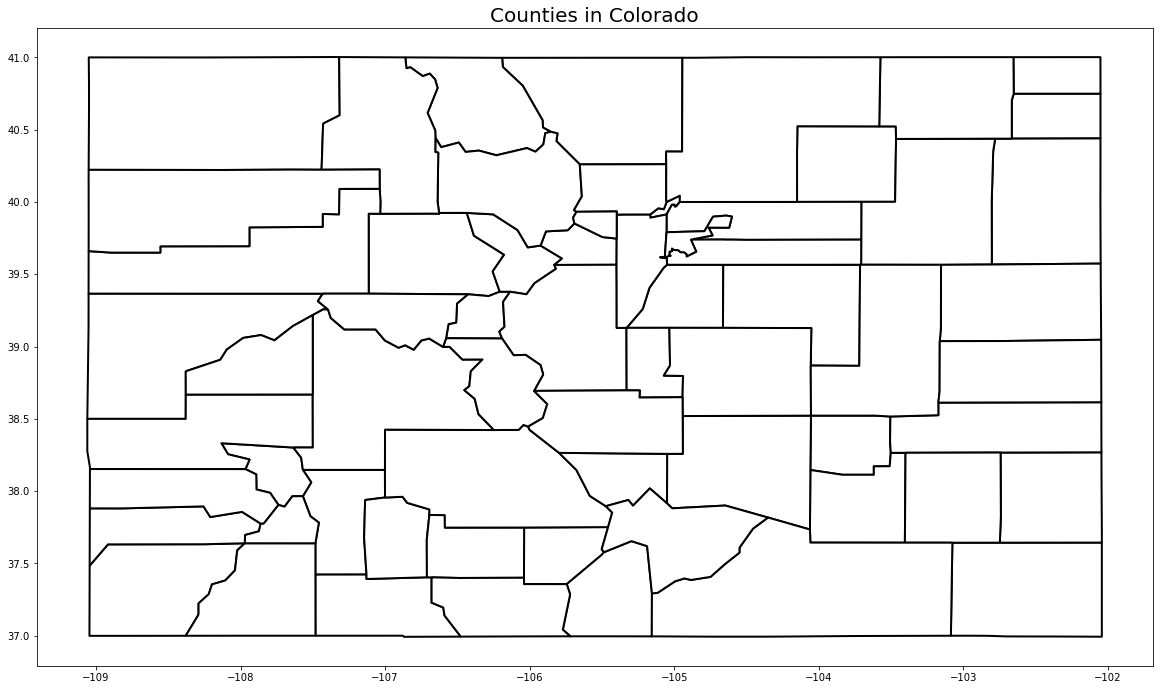

In [19]:
co_county_sf.plot(linewidth=2,facecolor="white",edgecolor="black",figsize=(20,14))
plt.title('Counties in Colorado', size=20)

### Feature Labeling

Use the axis method `annotate` to add labels to features.
In the example below, we put the name of the county at the geo-centroid of the county.

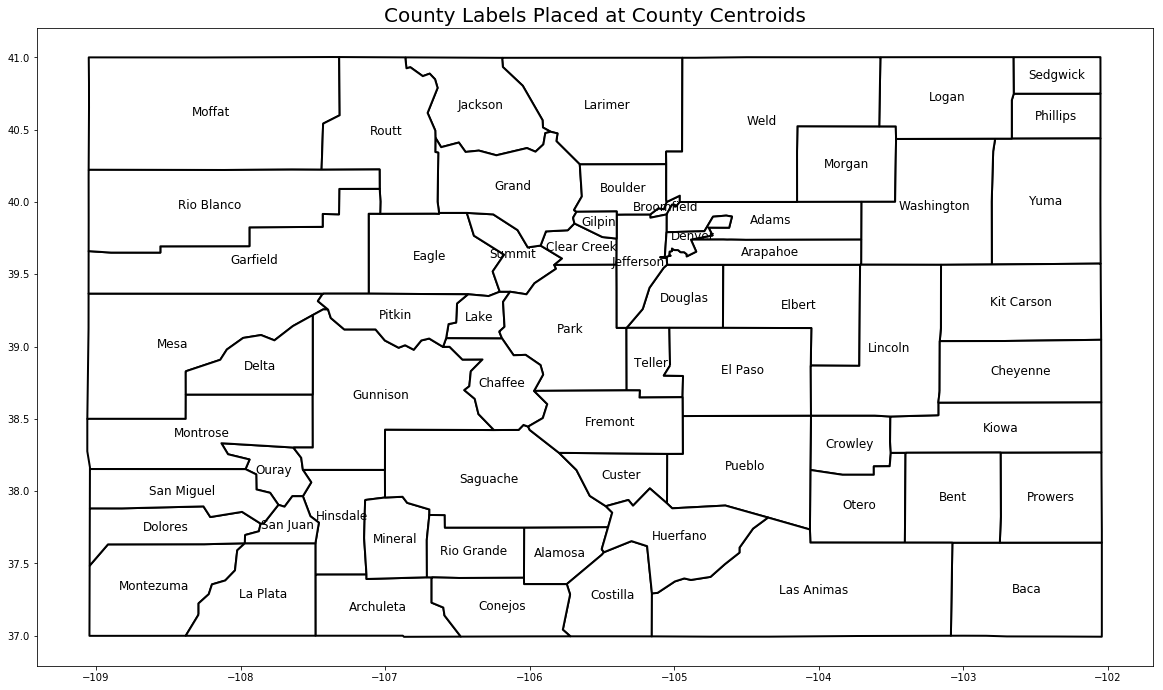

In [20]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')
co_county_sf.plot(ax=ax,linewidth=2,facecolor="white",edgecolor="black",figsize=(20,14))
for c in co_county_sf.itertuples():
    ax.annotate(c.NAME, xy=(c.geometry.centroid.x,c.geometry.centroid.y),
                                         va='center', ha='center', fontsize=12)

plt.title('County Labels Placed at County Centroids',size=20)
plt.show()    

Let's wrap the above in a function that we can reuse later in the notebook:

In [21]:
def plot_co_county(ax, fc='None', ec='grey',lw=1, fs=12):
    co_county_sf.plot(ax=ax,linewidth=lw,facecolor=fc,edgecolor=ec,)
    for c in co_county_sf.itertuples():
        ax.annotate(c.NAME, xy=(c.geometry.centroid.x,c.geometry.centroid.y),
                                         va='center', ha='center', fontsize=fs, color=ec)

In [22]:
co_county_sf.total_bounds

array([-109.060062,   36.992426, -102.041876,   41.003073])

In [23]:
type(co_county_sf.geometry.iloc[0])

shapely.geometry.polygon.Polygon

### Cities in Colorado

A shapefile describing the boundaries for the cities in Colorado came from:
[Colorado Information Marketplace](https://data.colorado.gov/Municipal/Municipal-Boundaries-in-Colorado/u943-ics6/data)
As in the case of the counties shapefile, we read up the cities shapefile with gpd.read_file:

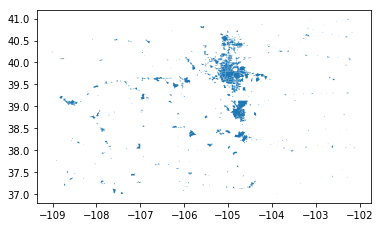

In [24]:
city_sf_path = "./data/shapefiles/Colorado Cities/Colorado_City_Boundaries.shp"
co_cities = gpd.read_file(city_sf_path)
co_cities.plot()

Lots of cities in Colorado! Let's prune it down to a few key cities and create a function for later use:

In [25]:
co_cities.columns

Index(['OBJECTID', 'GEOID10', 'NAME10', 'NAMELSAD10', 'Shape_Leng',
       'Shape_Area', 'geometry'],
      dtype='object')

In [26]:
my_cities = ['Denver', 'Loveland', 'Fort Collins', 'Colorado Springs', 'Castle Rock' ,'Greeley', 'Boulder',
            'Grand Junction', 'Pueblo', 'Limon','Fort Morgan', 'Sterling', 'Lakewood', 'Aurora',
            'Fort Morgan', 'Trinidad', 'Glenwood Springs', 'Julesburg']

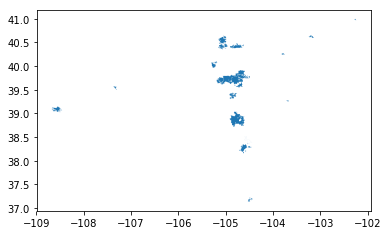

In [27]:
co_cities.query('NAME10 in @my_cities').plot()

In [28]:
def plot_co_cities(ax, fc='red', fs=10, subset=[]):
    
    if len(subset) == 0:
        cities = co_cities.copy()
    else: 
        cities = co_cities.query('NAME10 in @subset').copy()
    
    # where to put the labels
    cities['LabPoint'] = [(cty.geometry.bounds[2]+0.05,cty.geometry.bounds[3]) for cty in cities.itertuples()]
    
    # plot the cities
    cities.plot(ax=ax,facecolor=fc)
    
    # tack on the lables
    for c in cities.itertuples():
        ax.annotate(c.NAME10, xy=c.LabPoint,
                                         va='center', ha='left', fontsize=fs, color=fc)
    

## Plotting Arbitrary Points

You can put point data on a map (in this case, a point for each oil well in Colorado) by creating geopands `GeoSeries` from a list of `shapely` points.  All that is required to create a point is an x (longitude) and y (latitude) value.
The code below iterates through the oil_df dataframe and creates a `point` from each record's `long` and `lat` fields.

In [29]:
from shapely.geometry import Point
crs = {'init': 'epsg:4269'}
pts = gpd.GeoSeries([Point(w.long, w.lat) for w in oil_df.itertuples()],crs=crs)

In [30]:
pts.head()

0      POINT (-103.74812 39.85915)
1       POINT (-103.7482 39.86821)
2      POINT (-103.74813 39.87002)
3    POINT (-103.811653 39.978286)
4    POINT (-103.818583 39.981528)
dtype: object

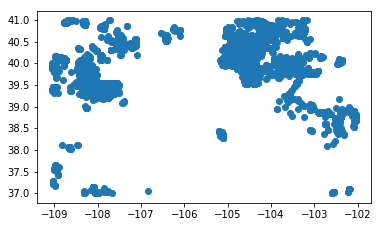

In [31]:
pts.plot()

## Map Layers

Let's plot these points along with our county and city boundaries. The trick to layering is to pass the `axis` along to the various plot functions and to set the axis' `aspect` to 'equal' as in the code below:

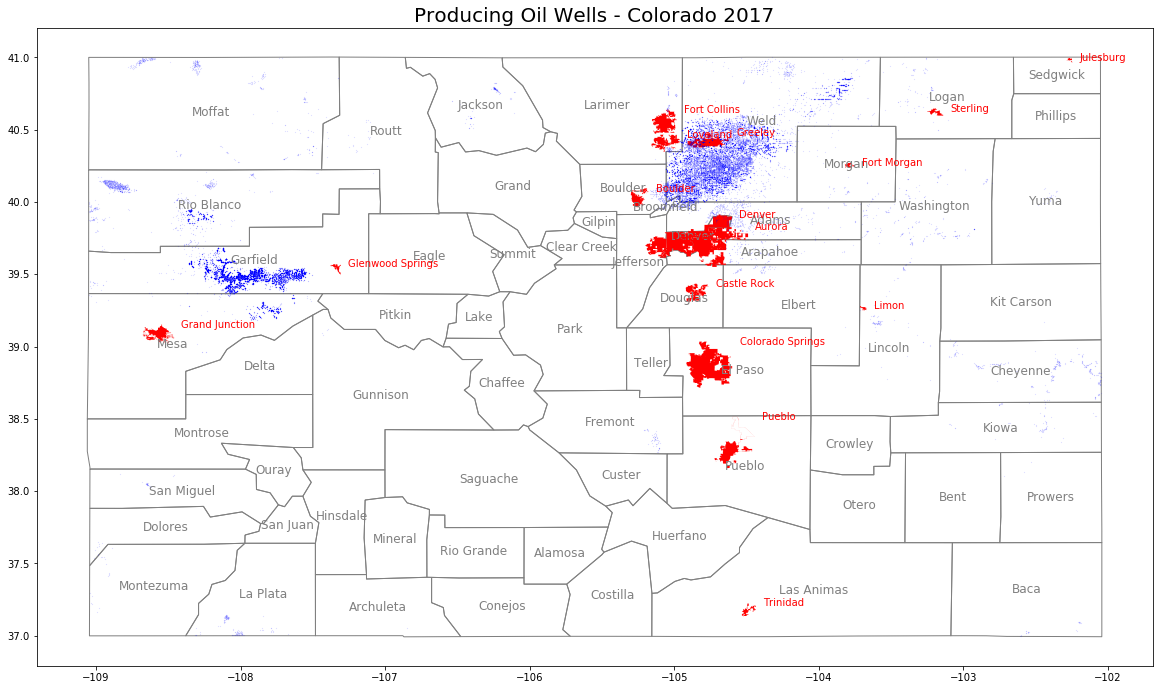

In [32]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

# counties as the first layer
plot_co_county(ax=ax)

# cities as the second layer
plot_co_cities(ax=ax, subset=my_cities)

# oil wells (as points) as third layer
pts.plot(ax=ax, marker='o', color='blue', markersize=0.025,alpha=0.3)

plt.title('Producing Oil Wells - Colorado 2017',size=20)

## GeoPandas from Pandas

You can create a `geopandas` DataFrame from a `pandas` DataFrame by calling the `GeoDataFrame` function and specifying the `geometry` values as follows:

In [33]:
pts = [Point(ll) for ll in zip(oil_df.long, oil_df.lat)]

crs = {'init': 'epsg:4269'}
oil_gdf = gpd.GeoDataFrame(oil_df, crs=crs, geometry=pts)

Now that we have `geopandas` DataFrame, we can slice, dice and plot in various ways.
In this example, we'll find the five most common formation codes (a geologic feature?) based on the number of wells and then plot them to see where they are in Colorado.

In [34]:
# find the 5 most common formation codes
top5 = oil_gdf.groupby('formation_code').size().sort_values(ascending=False).iloc[0:5]
top5.index

Index(['CODL  ', 'WFCM  ', 'NBRR  ', 'WMFK  ', 'N-COM '], dtype='object', name='formation_code')

In [35]:
# get a gdf that has just the wells that are in one of the top 5 formations.
top5_formations = oil_gdf.query('formation_code in @top5.index')

Plot it all out.  Note that the wells (points) for each formation code is its own layer on the map.

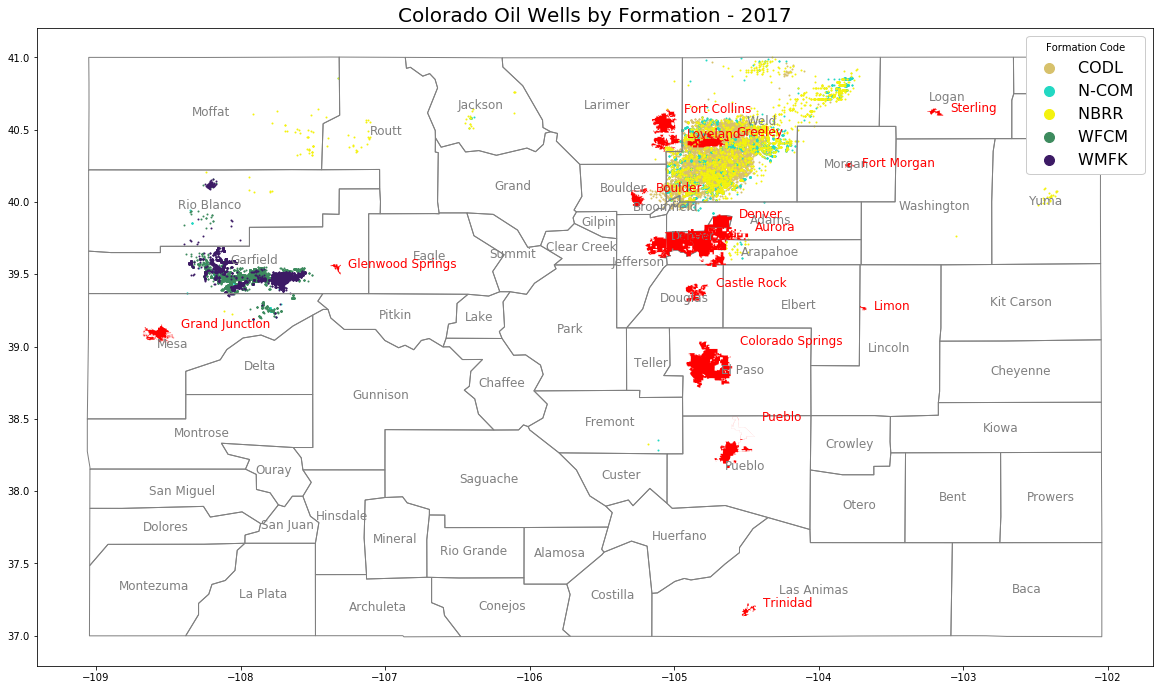

In [36]:
#create groups by formation code
groups = top5_formations.groupby('formation_code')

#colors for each group
colors = pd.tools.plotting._get_standard_colors(len(groups), color_type='random')

fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

# cylce through the groups plotting each with a unique color
ax.set_prop_cycle('color',colors)
for name, group in groups:
    group.plot(ax=ax, marker='o', markersize=1, label=name)

# county boundries
plot_co_county(ax=ax)

#city boundries
plot_co_cities(ax=ax,subset=my_cities,fs=12)

#legend
plt.legend(numpoints=1,fontsize=16,markerscale=10,title='Formation Code', facecolor="white",framealpha=1)

#title
plt.title("Colorado Oil Wells by Formation - 2017", size=20)

## Heatmap

A heatmap is form of a choropleth map in which the regions of the map are colored as a function of region's data values. More intense colors represent larger data values (i.e. more heat). The workflow sequence is as follows:

1. Construct a grid over the study area
2. Map point data to grid cells
3. Aggregate (sum) point data within each cell
3. Plot the grid with cell values on a color scale

### Construct a Grid over the Study Area

#### Grid Parameters

Here we get the longitude and latitude values for the endpoints of the gridlines

In [37]:
# Study area dimensions
bounds = co_county_sf.total_bounds.reshape(2,2)
x_min = bounds[0,0]; x_max = bounds[1,0]
y_min = bounds[0,1]; y_max = bounds[1,1]

#number of blocks in each direction
x_n = 10
y_n = 10

# longitudinal endpoints
x_vals, x_inc = np.linspace(x_min, x_max, x_n+1, retstep=True)

# Latitudinal endpoints
y_vals, y_inc = np.linspace(y_min, y_max, x_n+1, retstep=True)


#### Geopandas DataFrame for the Grid

Create `shapely` `LineStrings` (lines) from the grid parameters and create a `geopandas` DataFrame so that we can layer it on top of our map:

In [38]:
from shapely.geometry import LineString

#longitudinal gridlines
v_lines = [LineString([(x, y_min), (x, y_max)]) for x in x_vals]
# Latitudinal gridlines
h_lines = [LineString([(x_min, y), (x_max, y)]) for y in y_vals]

# centroids
block_centroids = []
#compute the centroids of each block in grid
#xx, yy = np.meshgrid(x_vals[0:x_n], y_vals[0:y_n])

#need x,y pairs
#xy = np.stack((np.matrix.flatten(xx), np.matrix.flatten(yy)), axis=1)

#offset by half the x_inc and y_inc values
#xy = xy + np.array([x_inc/2.0,y_inc/2.0]).reshape(1,2)

# convert to points
#block_centroids = [Point(xy[i,0],xy[i,1]) for i in range(xy.shape[0])]

# make a geopandas data frame out of it all
grid = gpd.GeoDataFrame(geometry=v_lines+h_lines+block_centroids)

#### Plot the Grid

Let's see what we have so far:

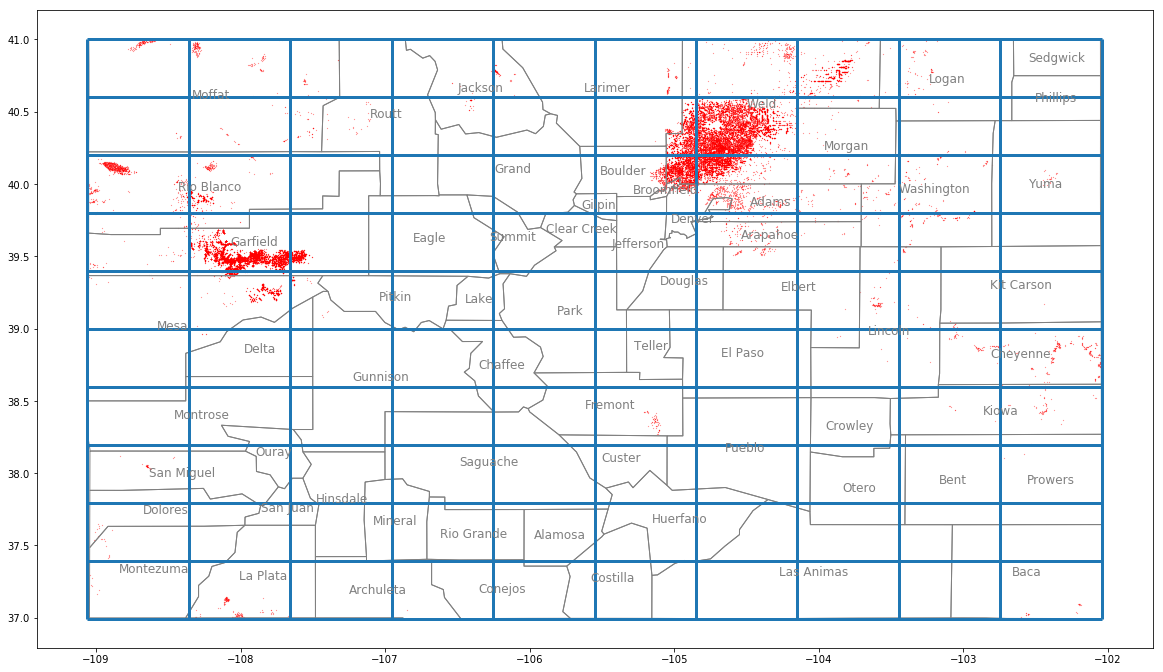

In [39]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')
oil_gdf.plot(ax=ax, marker='o', color='red', markersize=0.025,alpha=1)
# county boundries
plot_co_county(ax=ax)
grid.plot(ax=ax, linewidth=3)

To construct the heatmap, we'll total up the output (crude oil production) of each dot (an oil well) within each grid cell and then plot each cell with a color value.

### Map Point Data to Grid Cells

Using the grid parameters and arithmetic on the coordinates (long, lat) we can calculate the grid row and column index for each oil well:

In [40]:
from scipy.sparse import csr_matrix
oil_gdf.head()

,Prod_days,oil_prod,long,lat,formation_code,geometry
API_num,,,,,,
05-001-05242-00,145.0,473.0,-103.748120,39.859150,DSND,POINT (-103.74812 39.85915)
05-001-05289-00,344.0,5336.0,-103.748200,39.868210,JSND,POINT (-103.7482 39.86821)
05-001-05299-00,58.0,58.0,-103.748130,39.870020,DSND,POINT (-103.74813 39.87002)
05-001-05534-00,360.0,2167.0,-103.811653,39.978286,DSND,POINT (-103.811653 39.978286)
05-001-05542-00,34.0,37.0,-103.818583,39.981528,DSND,POINT (-103.818583 39.981528)


In [41]:
# map longitude and latitude to block columns and rows
oil_gdf['grid_col'] = np.floor((oil_gdf.long-x_min)/x_inc)
# Grid needs to flipped on lattitude axis (horizontal) because ndimage used below assumes origin in upper rigth corner
oil_gdf['grid_row'] = (y_n-1)-np.floor((oil_gdf.lat.values -y_min)/y_inc)

In [42]:
oil_gdf.head()

,Prod_days,oil_prod,long,lat,formation_code,geometry,grid_col,grid_row
API_num,,,,,,,,
05-001-05242-00,145.0,473.0,-103.748120,39.859150,DSND,POINT (-103.74812 39.85915),7.0,2.0
05-001-05289-00,344.0,5336.0,-103.748200,39.868210,JSND,POINT (-103.7482 39.86821),7.0,2.0
05-001-05299-00,58.0,58.0,-103.748130,39.870020,DSND,POINT (-103.74813 39.87002),7.0,2.0
05-001-05534-00,360.0,2167.0,-103.811653,39.978286,DSND,POINT (-103.811653 39.978286),7.0,2.0
05-001-05542-00,34.0,37.0,-103.818583,39.981528,DSND,POINT (-103.818583 39.981528),7.0,2.0


### Compute Grid Cell Totals

Compute the totals within each grid cell:

In [43]:
grid_totals = oil_gdf[['grid_row','grid_col','oil_prod']].groupby(['grid_row','grid_col']).sum()
grid_totals.reset_index(level=grid_totals.index.names, inplace=True)
grid_totals.query('oil_prod > 1000000')

,grid_row,grid_col,oil_prod
6,0.0,6.0,1309286.0
7,0.0,7.0,14312947.0
13,1.0,5.0,17386652.0
14,1.0,6.0,51183699.0
17,2.0,0.0,3438109.0
20,2.0,5.0,13170198.0
21,2.0,6.0,21391804.0
26,3.0,1.0,1050135.0


In [44]:
len(grid_totals)

51

#### Expland to Full (y_n, x_n) Matrix

The DataFrame above contains only for non-zero cells. In this case, only 51 out of the 100 possible cells have values.
We need the full matrix, including the 0-valued cells. Conveniently the above DataFrame looks a lot like a scipy csr_matrix (a sparse matrix representation).
We use `scipy.sparse.csr_matrix.toarray` method to get the full array:

In [45]:
heatmap=csr_matrix((grid_totals.oil_prod, (grid_totals.grid_row, grid_totals.grid_col)), shape=( y_n,x_n)).toarray()

### Plot Cell Totals on Colorscale

Given the large variation in cell values, we'll plot on a log-scale.  Also, we'll perform a two-dimensional smoothing so that the changes from one block to the next are not quite so abrupt:

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: divide by zero encountered in log


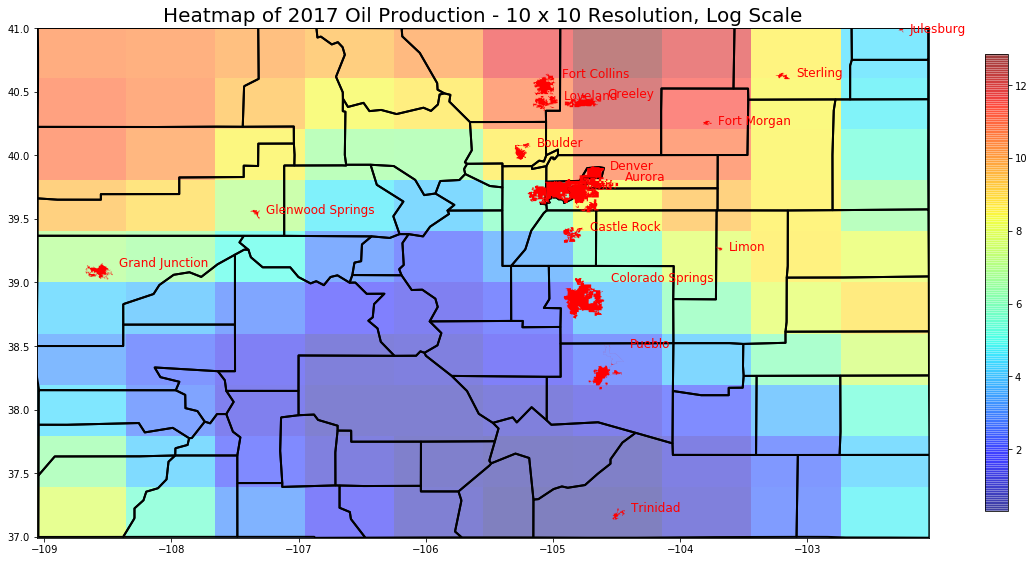

In [46]:
from scipy import ndimage
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

extent = [x_min, x_max, y_min, y_max]

smoothing=1.3
cmap='jet'

logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
plt.imshow(logheatmap, cmap=cmap,extent=extent, alpha=0.5)
plt.colorbar(shrink=0.6)
#plt.gca().invert_yaxis()

co_county_sf.plot(ax=ax, linewidth=2, facecolor='none', edgecolor='black')
#city boundries
plot_co_cities(ax=ax,subset=my_cities,fs=12)

plt.title('Heatmap of 2017 Oil Production - 10 x 10 Resolution, Log Scale', size=20)
plt.show()

### Heatmap Function

Wrap all of the above into a function so that we can reuse the calculations and vary the parameters:

In [47]:
def make_heatmap(d, bounds, bins=(10,10), log=True, Longitude = 'Longitude', Latitude = 'Latitude', val='Value', smoothing=1.3):
    
    #boundaries and number of x and y bins:
    xmin, ymin, xmax, ymax = bounds
    xbins, ybins = bins
    
    #cell width:
    xinc = (xmax - xmin)/xbins
    yinc = (ymax - ymin)/ybins
    
    #data frame columns we're interested in
    longi = d.columns.get_loc(Longitude)
    lati  = d.columns.get_loc(Latitude)
    vali  = d.columns.get_loc(val)
    
    #map the input longitude and Latitude into their corresponding column and row indices
    gridified = pd.DataFrame({'row_i':(ybins-1)-np.floor((d.iloc[:,lati]-ymin)/yinc), #y-axis needs to be flipped
                              'col_i': np.floor((d.iloc[:,longi]-xmin)/xinc),
                              'Value': d.iloc[:,vali]})
                              
    #get totals for each cell
    cell_totals = gridified.groupby(['row_i','col_i']).sum()
    cell_totals.reset_index(level=cell_totals.index.names, inplace=True)
    
    # expand out to a full matrix with shape (ybins, xbins)
    heatmap=csr_matrix((cell_totals.Value, (cell_totals.row_i, cell_totals.col_i)), shape=(ybins,xbins)).toarray()
    
    # compute log if desired
    if log:
        heatmap = np.log(heatmap)
        heatmap[np.isneginf(heatmap)] = 0
   
    # smooth over the values:    
    #heatmap = ndimage.filters.gaussian_filter(heatmap, smoothing, mode='nearest')
    
    return heatmap

### High(er) Resolution Heatmap

Make a higher resolution by increasing the number of bins in both the longitude and latitude directions

In [48]:
bounds = co_county_sf.total_bounds
hm = make_heatmap(oil_gdf,bounds,bins=(200,200),Longitude='long',Latitude='lat',val='oil_prod')

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: RuntimeWarning: divide by zero encountered in log


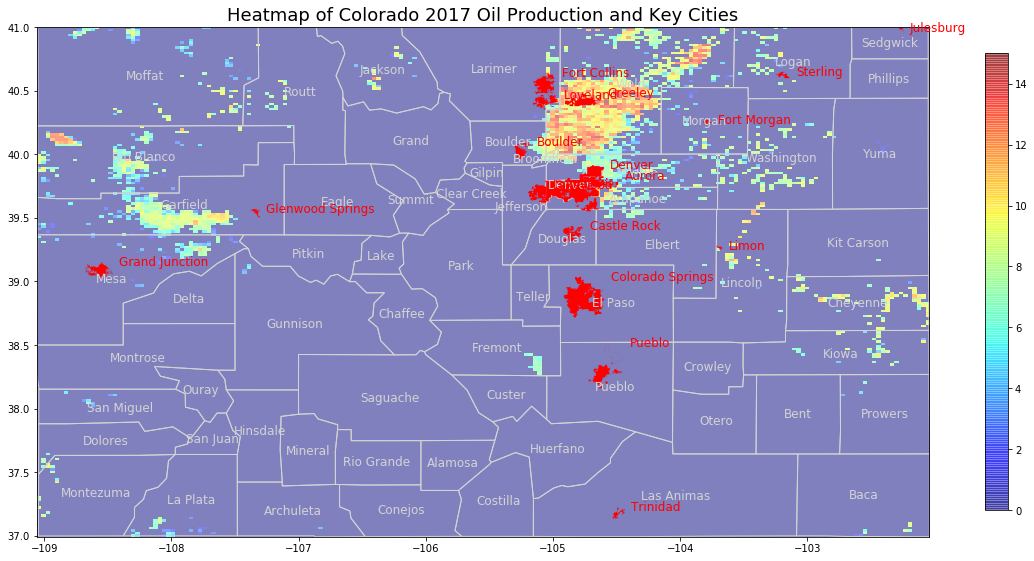

In [49]:
fig, ax = plt.subplots(figsize=(20,14))
ax.set_aspect('equal')

extent = [bounds[0], bounds[2], bounds[1], bounds[3]]

smoothing=1.3
cmap='jet'

# put up  the heatmap & color bar
plt.imshow(hm, cmap=cmap,extent=extent, alpha=0.5)
plt.colorbar(shrink=0.6)

# layer on the counties and cities
plot_co_county(ax=ax, fc='none', ec='lightgrey')
plot_co_cities(ax=ax,subset=my_cities,fc='red',fs=12)

# jazzy title
plt.title('Heatmap of Colorado 2017 Oil Production and Key Cities',fontsize=18)

# show it
plt.show()

## Spatial Join

We can use a spatial join, similar to a relational join, to determine among other things, which points fall within which polygons.
To illustrate, we'll find which oil wells (points) fall within the city boundaries (polygons) of Fort Collins, Lovelans and Greeley.
`geopandas.sjoin` does the heavy lifting.

In [50]:
NoCo_Cities = co_cities.query('NAME10 in [\'Fort Collins\', \'Loveland\', \'Greeley\']')

In [51]:
Wells_in_NoCo_Cities = gpd.sjoin(oil_gdf, NoCo_Cities, how="inner", op='intersects')

In [52]:
Wells_in_NoCo_Cities.head()

,Prod_days,oil_prod,long,lat,formation_code,geometry,grid_col,grid_row,index_right,OBJECTID,GEOID10,NAME10,NAMELSAD10,Shape_Leng,Shape_Area
05-069-06071-00,107.0,495.0,-105.048930,40.630517,MDDY,POINT (-105.04893 40.630517),5.0,0.0,45,46,0827425,Fort Collins,Fort Collins city,2.122736,0.015291
05-069-06076-00,361.0,2517.0,-105.053409,40.632129,MDDY,POINT (-105.053409 40.632129),5.0,0.0,45,46,0827425,Fort Collins,Fort Collins city,2.122736,0.015291
05-069-06087-00,100.0,495.0,-105.043818,40.628909,MDDY,POINT (-105.043818 40.628909),5.0,0.0,45,46,0827425,Fort Collins,Fort Collins city,2.122736,0.015291
05-069-06094-00,364.0,1562.0,-105.045891,40.635886,MDDY,POINT (-105.045891 40.635886),5.0,0.0,45,46,0827425,Fort Collins,Fort Collins city,2.122736,0.015291
05-069-06311-00,344.0,3082.0,-105.047777,40.625521,MDDYJ,POINT (-105.047777 40.625521),5.0,0.0,45,46,0827425,Fort Collins,Fort Collins city,2.122736,0.015291


Let's see where they are:

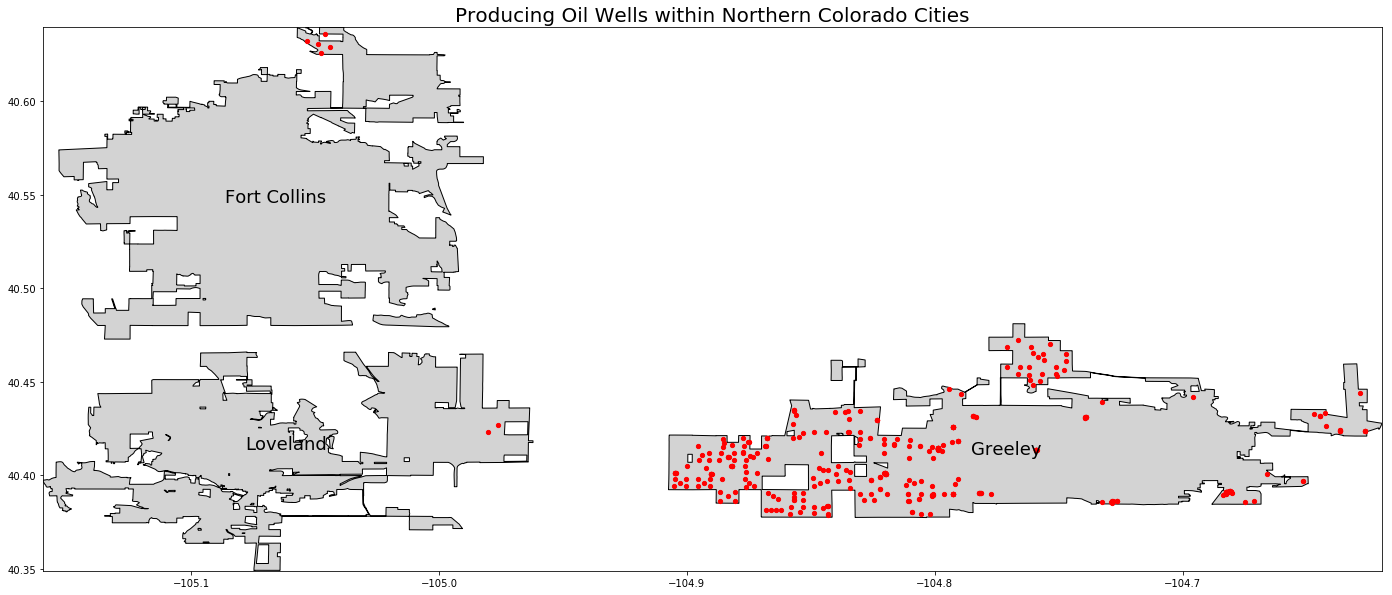

In [53]:
x0,y0,x1,y1 = NoCo_Cities.total_bounds

fig, ax = plt.subplots(1,figsize=(24,10))
ax.set_xlim(x0,x1)
ax.set_ylim(y0,y1)

NoCo_Cities.plot(ax=ax,edgecolor='black', facecolor='lightgrey')
Wells_in_NoCo_Cities.plot(ax=ax, markersize=18, color='red')

# city labels:
for c in NoCo_Cities.itertuples():
    ax.annotate(c.NAME10, xy=(c.geometry.centroid.x,c.geometry.centroid.y),
                              va='center', ha='center', fontsize=18, color='black')
plt.title('Producing Oil Wells within Northern Colorado Cities',size=20)

In [54]:
Wells_in_NoCo_Cities.query('NAME10 == \'Loveland\'')

,Prod_days,oil_prod,long,lat,formation_code,geometry,grid_col,grid_row,index_right,OBJECTID,GEOID10,NAME10,NAMELSAD10,Shape_Leng,Shape_Area
05-069-06180-00,61.0,252.0,-104.97627,40.42706,NBRR,POINT (-104.97627 40.42706),5.0,1.0,43,44,0846465,Loveland,Loveland city,2.3156,0.009636
05-069-06194-00,42.0,446.0,-104.98008,40.42334,CODL,POINT (-104.98008 40.42334),5.0,1.0,43,44,0846465,Loveland,Loveland city,2.3156,0.009636


## Paste these coordinates into Google Earth!

In [55]:
Wells_in_NoCo_Cities.query('NAME10 == \'Loveland\'')[['lat','long']]

,lat,long
05-069-06180-00,40.42706,-104.97627
05-069-06194-00,40.42334,-104.98008
